In [1]:
## Import base libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd
import GPy

## Packages
In notebooks 1 through 5, we've constructed a GPR and have learned how to optimize it from scratch for educational purposes. Moving forward, rather than reinventing the wheel, we will use python packages as substitues for the functions we've wrote as they're more computationally efficient and robust.
<br><br>

**PyMC (not used here)**
PyMC is a popular _probabilistic programming_ framework featuring advanced MCMC sampling algorithms such as No-U-Turn Sampler (NUTS; Hoffman, 2014), an update of Hamiltonian Monte Carlo, which work well on high-dimensional posterior distributions. NUTS achieves faster convergence than traditional Monte Carlo sampling methods and is self-tuning. PyMC transcodes models to C and compiles them to machine code, thereby boosting performance.
<br><br>

**Sampyl**
A python package for Bayesian inference using MCMC methods, including posterior distribution estimation. It offers several MCMC algorithms including Metropolis-Hastings, Hamiltonian Monte Carlo (HMC), and No-U-Turn Sampler (NUTS).
<br><br>
**GPy**
Is a popular python package that provides a framework for easy implementation of GP modeling.
<br><br>
Sources used:
* https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html

In [2]:
## List of functions for GPR ##
## ============================ ##
#MCMC MH implementation to optimize l and sigma only
def mcmc_mh(a,b,N,fixed_par,target_par,X,y,og = True,density = None):
    '''
    a = [a_l, a_simga, ...] is an array of the lower bounds of the MCMC search
    b = [b_l, b_sigma, ...] is an array of the upper bounds of the MCMC search
    fixed_par = [*,*,...] is an array of the initial values of the parameters that won't change (like sigma_n)
    target_par = [*,*,...] is an array of the initial values of the target parameters (like l and sigma)
    X is the feature variable
    y is the response
    og = original MCMC (first level of Bayesian update)
    '''
    

    #Define priors
    def log_prior(target):
        '''
        target_i is an iterate of the target array [l, sigma, ...]
        a_i is an iterate of the array a
        b_i is an iterate of the array b
        '''
        logval = 0
        for j in range(len(target)):
            if (target[j] <= a[j] or target[j] >= b[j]):
                value = 0.00001
            else:
                if og == True:
                    value = 1 #/target[i] #change for Jeffreys prior
                else:
                    value = pdf_post(target[j],density)
            logval = logval + np.log(value+0.00001)
        return logval

    
    targets = []
    for j in range(len(target_par)):
        targets.append(np.zeros(N))
        targets[j][0] = target_par[j]


    #Fix unwanted hyperparameters
    fixed = []
    for j in range(len(fixed_par)):
        fixed.append(np.zeros(N))
        fixed[j][0] = fixed_par[j]
    
    
    accept_count = 0
    for i in range(1, N):
        #1) Propose new position theta[i-1] -> theta[i]' by sampling from proposal distro
        target_prop = []
        for j in range(len(targets)):
            target_prop.append(np.random.uniform(a[j], b[j]))

        #2) Compute log of acceptance ratio
        prop = log_like(target_prop, X, y, kernel, noise = 0, input_dim = 1) + log_prior(target_prop)
        target_prev = []
        for j in range(len(targets)):
            target_prev.append(targets[j][i-1])
        prev = log_like(target_prev, X, y, kernel, noise = 0, input_dim = 1) + log_prior(target_prev)

        log_alpha = min(prop - prev, 0)  # Acceptance ratio

        #3) Generate a random number u_i from [0,1]
        u = np.random.uniform(0,1) #u_i

        #4)
        if u <= np.exp(log_alpha):
            good = True
            for j in range(len(targets)):
                if 0 < target_prop[j]:
                    continue
                else:
                    good = False
                    break
            if good == True:
                # Accept y as next state
                for j in range(len(targets)):
                    targets[j][i] = target_prop[j]
                accept_count = accept_count + 1
            else:
                # Stay at previous state of Markov chain
                for j in range(len(targets)):
                    targets[j][i] = target_prev[j]
        else:
            # Stay at previous state of Markov chain
            for j in range(len(targets)):
                targets[j][i] = target_prev[j]
            
    #--- Returns ---
    ##
    accept_rate = accept_count/N #acceptance rate
    n = int(0.95*N) #number of samples of the posterior
    posteriors = []
    for j in range(len(targets)):
        posteriors.append(targets[j][-n:])
    ##
    #KDE estimate of posterior density pdf:
    #for pdf, add .pdf([array points you want to evaluate]) to end of density
    densities = []
    eval_points = []
    dc = []
    MAPs = []
    for j in range(len(targets)):
        densities.append(stats.gaussian_kde(posteriors[j], bw_method='scott'))
        eval_points.append(np.linspace(np.min(posteriors[j]), np.max(posteriors[j]), num=1000))
        dc.append( (np.max(eval_points[j]) - np.min(eval_points[j]))/999 )
        MAPs.append( eval_points[j][np.argmax(densities[j].pdf(eval_points[j]))] )
    
    return posteriors, densities, eval_points, dc, MAPs, n, accept_rate


#Define wrapper function to optimize certain params
def negative_log_like(params, X, y, kernel, noise = 0, input_dim = 1):
    m = GPy.models.GPRegression(X,y,kernel)
    m[:] = np.append(params, noise)
    m.Gaussian_noise.variance = noise # (Reset the parameter first)
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    obj_funct = m.log_likelihood()
    return -1*obj_funct #return negative log-likelihood


def log_like(params, X, y, kernel, noise = 0, input_dim = 1):
    m = GPy.models.GPRegression(X,y,kernel)
    m[:] = np.append(params, noise)
    m.Gaussian_noise.variance = noise # (Reset the parameter first)
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    obj_funct = m.log_likelihood()
    return obj_funct #return negative log-likelihood


#Define Likelihood optimization method
def optimize_like(negative_log_like, params0, args, method = "L-BFGS-B"):
    opt_par = minimize(negative_log_like, params0, args=args, method=method, options = {'disp':True})
    print("Number of iterations = ", opt_par.nit)
    print("Min of obj funct = ", opt_par.fun)
    return opt_par.x #return optimal parameters


def GPy_optimize_like(m, optimizer = "lbfgs", noise = 0):
    '''
    Optimizer methods: 'scg','lbfgs','org-bfgs','fmin_tnc','adam'
    '''
    m.Gaussian_noise.variance = noise
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    m.optimize(optimizer = optimizer)
    
    return m[:-1]


## List of functions for 1D GPR ##
## ============================ ##
#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
f_scaled = lambda x, minX, maxX: f((maxX - minX)*x+minX) #only if X and not y is scaled


#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    #print(ysmall)
    ysmall_x = X[ysmall_i]
    #print(ysmall_x)
    wavelength = 2*np.abs(ymax_x - ysmall_x)
    #print(wavelength)
    return wavelength[0]


def rbf_init_par(X,y):
    init_sigma_n = 0#0.0001 #np.std(y) # guess for observation noise
    init_len_scale = wavelength(X,y)
    init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations
    init_par = [init_sigma_n, init_len_scale, init_sigma_f]
    return init_par


#plot the posterior distribution of GPR
def plot_post(X, y, kernel, noise = 0):
    '''
    Plot the posterior distribution of GPR
    '''
    N = len(X)
    n = 200 # number of test points X*
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    
    #Return mu and std:
    m = GPy.models.GPRegression(X,y,kernel)
    m.Gaussian_noise.variance = noise # (Reset the parameter first)
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f_scaled(Xtest,minX,maxX), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    

#plot the posterior distribution of GPR (GPy version)
def GPy_plot_post(m, X, y):
    '''
    Plot the posterior distribution of GPR
    '''
    N = len(X)
    n = 200 # number of test points X*
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f_scaled(Xtest,minX,maxX), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    
    
## List of functions for 2D GPR ##
## ============================ ##

## 1D Problem

0.625


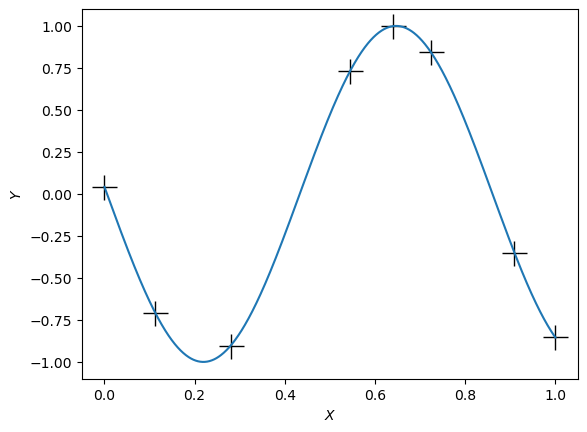

In [3]:
#This is our dataset:
Nog = 8
Xog = np.sort(generate_points(-5, 5, Nog, dim = 1),axis = 0)
#X = np.array([[0],[0.175],[0.55],[0.8],[1]])
y = (f(Xog) + np.random.normal(0,0,Nog)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Function we'd like to estimate --> our goal
xog = np.arange(min(Xog)-abs(min(Xog))*0.2, max(Xog)+abs(max(Xog))*0.2, 0.01).reshape(-1,1)

#Normalize feature: X training points, x testing points in between
minX = np.min(Xog)
maxX = np.max(Xog)
X = (Xog - minX)/(maxX - minX) #X in [0,1]

x = xog.reshape(-1,1)
x = (xog - np.min(xog))/(np.max(xog) - np.min(xog)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guess

In [4]:
#Initial guesses of kernel hyperparameters#
init_par = rbf_init_par(X,y)
print(init_par) #sigma_n, l, sigma_f

[0, 0.7183691220091659, 1.9013316126252753]


Define a GP model with its kernel:

  index  |  rbf.lengthscale  |  constraints  |  priors
  [0]    |       0.71836912  |      +ve      |        
  index  |  rbf.variance  |  constraints  |  priors
  [0]    |    1.90133161  |      +ve      |        


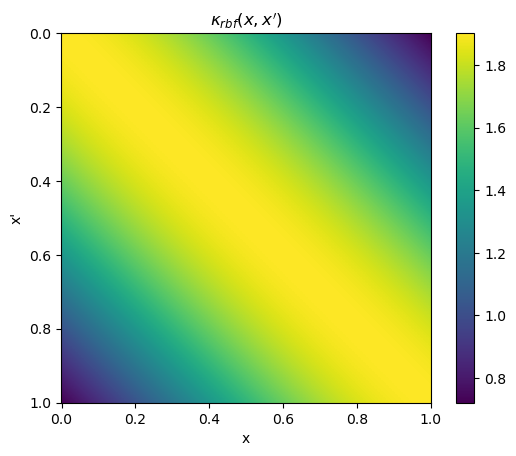

In [5]:
# Define Kernel
#---------------
#RBF kernel with input dimension 1, variance 1, and lengthscale 1
kernel = GPy.kern.RBF(input_dim=1, variance=init_par[2], lengthscale=init_par[1])
#kern.variance.fix(val) if you want to fix the value of this parameter
#---------------

# Plot kernel
K = kernel.K(x,x)

# Plot the covariance of the sample space
plt.pcolor(x.T, x, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

#return the lengthscale and variance of kernel
print(kernel.lengthscale)
print(kernel.variance)

---
---
## Investigating 2 hyperparameters: $l$ and $\sigma_f$
**Approach 1: Type II maximum likelihood (we have done before, see 2_LikelihoodModelSelection)**
<br>We want to maximize the marginal log-likelihood:
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br>
We can do this with a finite difference method L-BFGS-B (variation of gradient-descent method):

In [6]:
#Initial guess for sigma and l
params0 = [init_par[2], init_par[1]]
params0

[1.9013316126252753, 0.7183691220091659]

Optimization terminated successfully.
         Current function value: 0.465232
         Iterations: 50
         Function evaluations: 96
Number of iterations =  50
Min of obj funct =  0.46523161213228903
sigma = 1.832051, l = 0.306933


<Figure size 640x480 with 0 Axes>

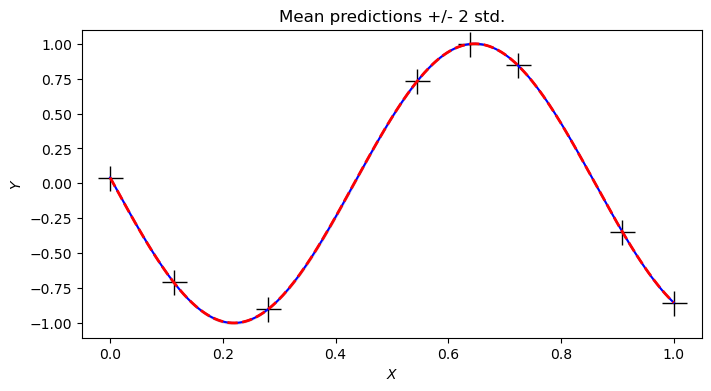

In [7]:
#Optimize
kernel = GPy.kern.RBF(input_dim=1, variance=init_par[2], lengthscale=init_par[1])
sigma, l = optimize_like(negative_log_like, params0, args=(X,y,kernel), method="Nelder-Mead")
print("sigma = %f, l = %f" % (sigma, l) )

#plot optimized parameters
kernel = GPy.kern.RBF(input_dim = 1, variance = sigma, lengthscale = l)
plot_post(X, y, kernel)

sigma = 1.832003, l = 0.306932


 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


<Figure size 640x480 with 0 Axes>

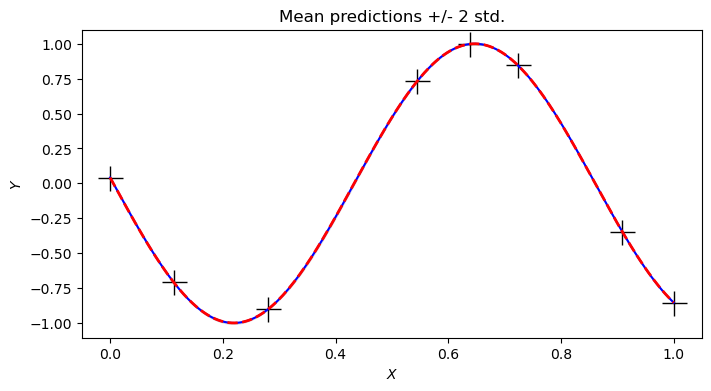

In [8]:
kernel = GPy.kern.RBF(input_dim=1, variance=init_par[2], lengthscale=init_par[1])
m = GPy.models.GPRegression(X,y,kernel)
sigma, l = GPy_optimize_like(m)
print("sigma = %f, l = %f" % (sigma, l) )

GPy_plot_post(m, X, y)

---
**Approach 2: MCMC method**
<br>
We would like to find the posterior over the hyperparameters from Bayes' rule:
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
where $p(\theta)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood (evidence) is
$$
p(y\vert X) = \int p(y\vert X,\theta)p(\theta) d\theta
$$
So far we've used the MCMC method Metropolis-Hastings (MH) as our sampler which wasn't the most efficient and may require a long time to converge. Hamiltonian Monte Carlo (HMC) uses first-order gradients of the log posterior rather than a random walk. The latest sampling technique is called the No-U-Turn Sampler (NUTS), an upgrade from HMC. Unlike HMC, NUTS does not require us to specify the number of steps or step size parameters, which it automatically determines through each iteration.
<br><br>
We'll continue to use the Metropolis-Hastings algorithm for now. In the next notebook we'll implement GPs with PyMC, which utilizes NUTS in its update of the posterior.

In [9]:
#Initials
a_l = 0.00001
b_l = 10
a_sigma = 0.00001
b_sigma = 5

a = [a_sigma, a_l]
b = [b_sigma, b_l]
N = 2000
fixed_par = [init_par[0]]
#use the values of sigma and l optimized from a gradient-based method as the starting parameters
target_par = [abs(sigma),abs(l)] #params0

posteriors, densities, eval_points, dc, MAPs, n, accept_rate = mcmc_mh(a,b,N,fixed_par,target_par,X,y,og = True,density = None)

MAPs of l and sigma:  3.888600349894593  , 0.3631138184973446


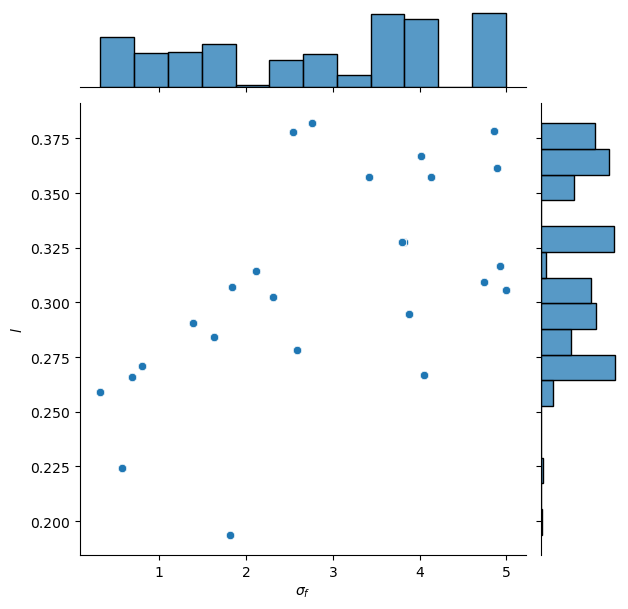

In [10]:
#Distribution of l and sigma
print("MAPs of l and sigma: ",MAPs[0]," ,",MAPs[1])
C, D = posteriors[0], posteriors[1]
sns.jointplot(x=C,y=D, kind='scatter')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

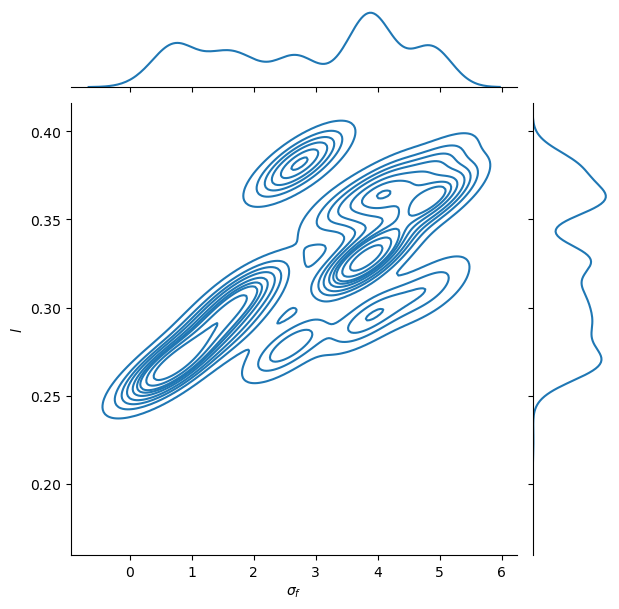

In [11]:
#Distribution of l and sigma
sns.jointplot(x=C,y=D, kind='kde')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

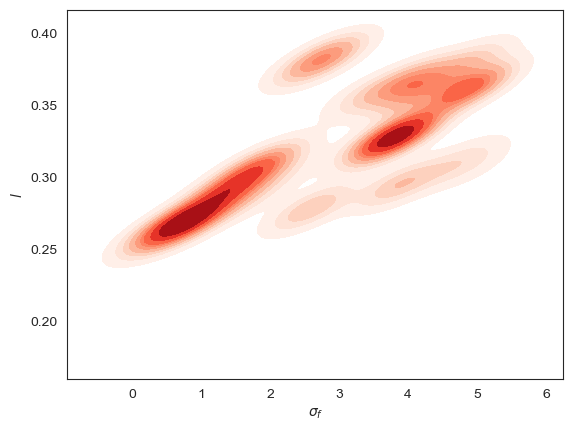

In [12]:
sns.set_style("white")
sns.kdeplot(x=C, y=D, cmap="Reds", fill=True)
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

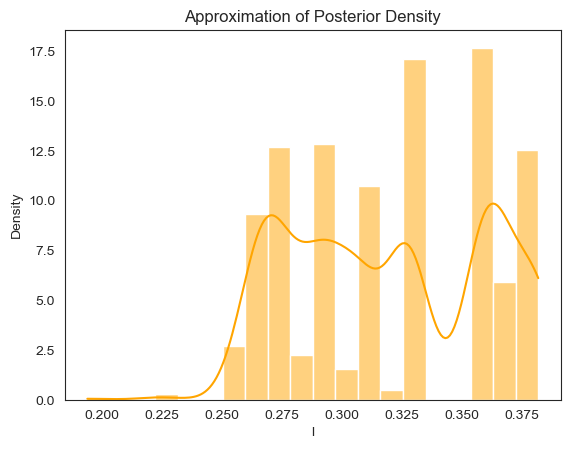

In [13]:
# Plot of MCMC approximation of the posterior
sns.histplot(D, kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

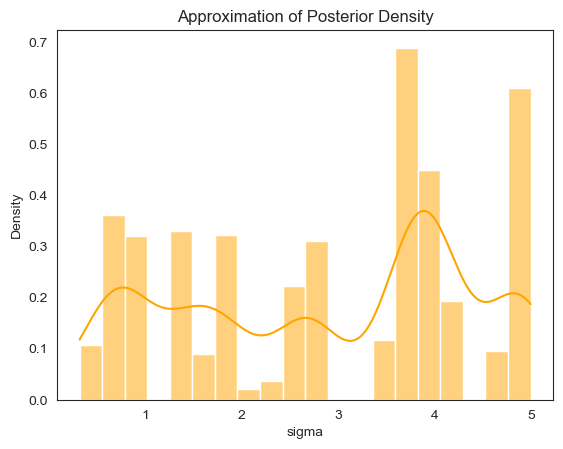

In [14]:
# Plot of MCMC approximation of the posterior
sns.histplot(C, kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

---
Let's implement the Hybrid Monte Carlo through GPy:

In [15]:
m = GPy.models.GPRegression(X,y,kernel)
#m.unconstrain()

#Make a gamma prior and set it as the prior for the lengthscale
gamma_prior = GPy.priors.Gamma.from_EV(1.5,0.7)

#Make a uniform prior and set it as the prior for the variance
uniform_prior = GPy.priors.Uniform(0,5)

m.rbf.lengthscale.set_prior(gamma_prior)
m.rbf.variance.set_prior(gamma_prior)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


 C:\Users\Sasha\anaconda3\lib\site-packages\GPy\core\parameterization\priors.py:352: RuntimeWarning:invalid value encountered in log


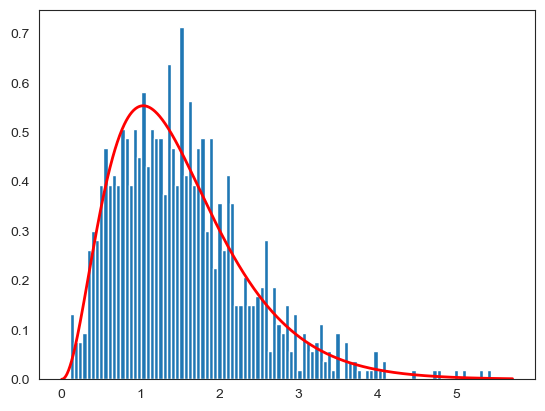

In [16]:
gamma_prior.plot()

In [17]:
m.Gaussian_noise.variance = 0
m.Gaussian_noise.variance.fix()
m.optimize()
m

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
rbf.variance,1.5120722605991732,+ve,"Ga(3.2, 2.1)"
rbf.lengthscale,0.30361625435591433,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,0.0,+ve fixed,


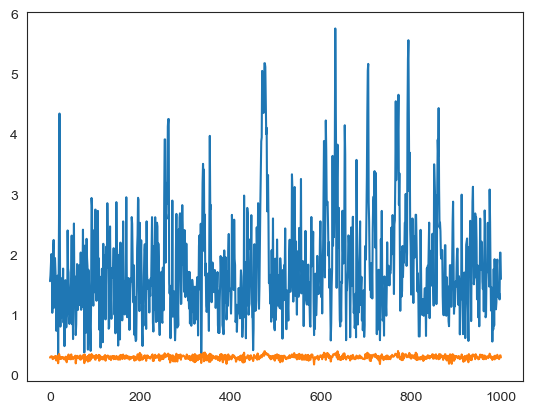

In [18]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s = hmc.sample(num_samples=1000) # Burnin

#plot the samples
plt.plot(s)

Text(0, 0.5, 'lengthscale')

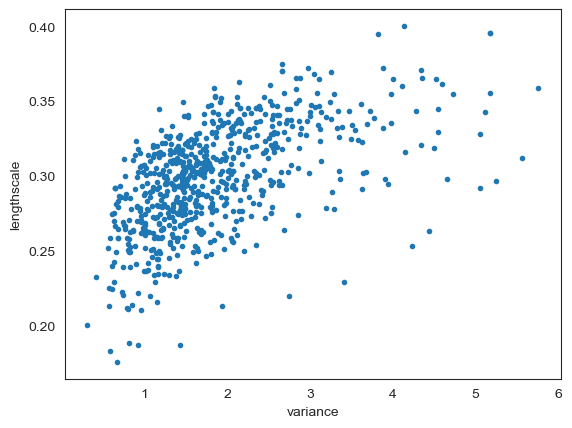

In [19]:
labels = ["variance","lengthscale"]
samples = s[300:] # cut out the burn-in period
plt.plot(samples[:,0], samples[:,1],'.')
plt.xlabel(labels[0]); plt.ylabel(labels[1])

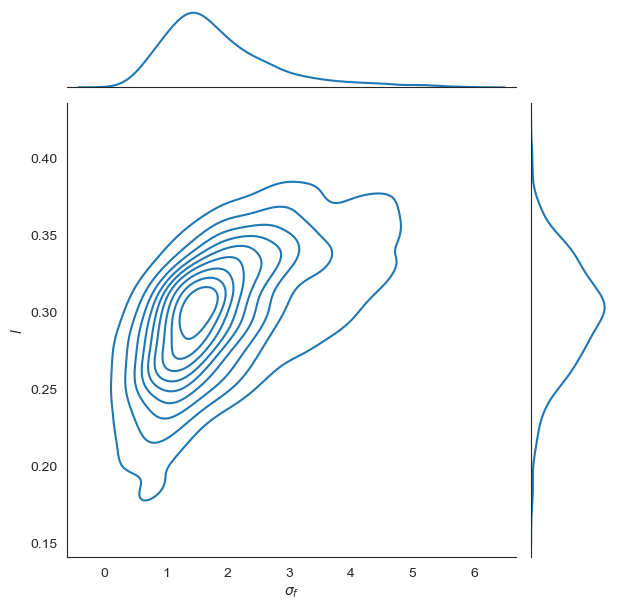

In [20]:
#Distribution of l and sigma
sns.jointplot(x=samples[:,0],y=samples[:,1], kind='kde')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

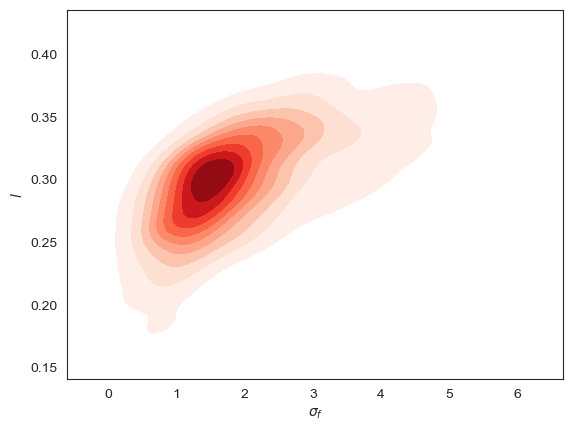

In [21]:
sns.set_style("white")
sns.kdeplot(x=samples[:,0], y=samples[:,1], cmap="Reds", fill=True)
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

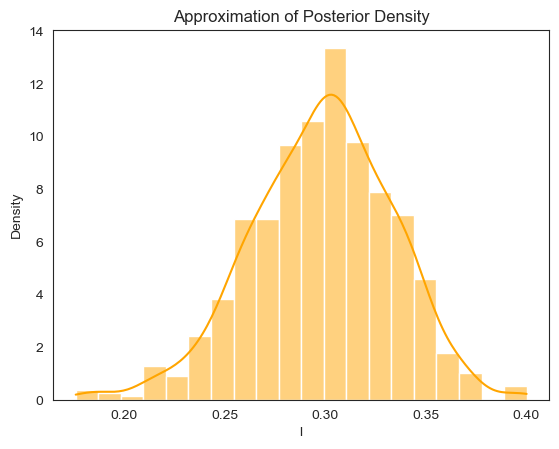

In [22]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples[:,1], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

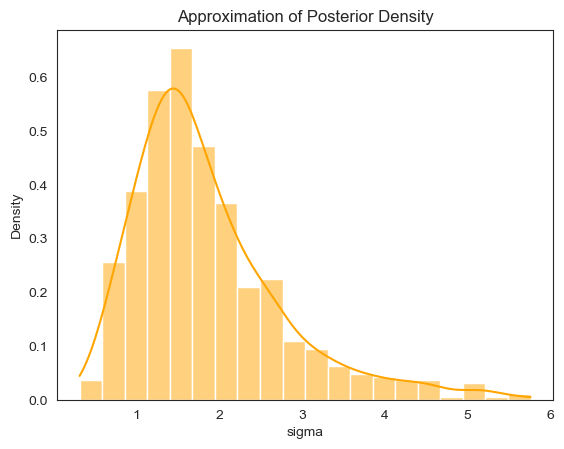

In [23]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples[:,0], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

**Adaptive sampling**
<br>
We now add a new observation at the point of maximum variance. We use the previous posterior distributions for $l$ and $\sigma_f$ as the priors for the new posterior distributions.

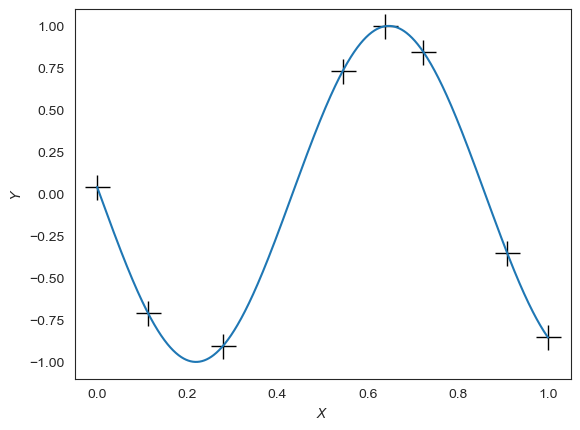

In [24]:
#Original plot
#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [25]:
#Xtest that returns largest predictive std is
def find_Xtest(m, X, y):
    Xtest_og = np.linspace(min(X), max(X), n).reshape(-1,1)
    mu, std = m.predict_noiseless(Xnew = Xtest_og, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    Xtest_maxstd = Xtest_og[np.argmax(std)][0]
    return Xtest_maxstd

Xtest_maxstd = find_Xtest(m,X,y)
Xtest_maxstd

0.3870458135860979

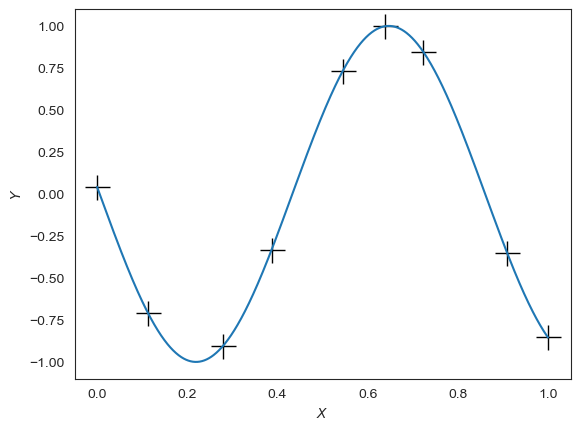

In [26]:
X_new = X
Xnew = np.sort(np.append(X_new,Xtest_maxstd)).reshape(-1,1)
Xognew = (maxX - minX)*Xnew + minX
ynew = (f(Xognew) + np.random.normal(0,0,Nog+1)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot
plt.plot(Xnew, ynew, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [27]:
from GPy.core.parameterization.priors import Prior
import weakref
class KDEPrior(Prior):
    _instances = []

    def __new__(cls, samples):  # Singleton:
#         if cls._instances:
#             cls._instances[:] = [instance for instance in cls._instances if instance()]
#             for instance in cls._instances:
#                 if instance().samples == samples:
#                     return instance()
        newfunc = super(Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)
        else:
            o = newfunc(cls, samples)
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()

    def __init__(self, samples):
        self.samples = samples
        self.kde = gaussian_kde(self.samples)

    def __str__(self):
        return "KDE"

    def lnpdf(self, x):
        return np.log(self.kde.pdf(x))

    def lnpdf_grad(self, x):
        # Approximate the gradient by calculating the difference in the log PDF at two close points
        epsilon = 1e-8
        log_pdf_grad = (np.log(self.kde.pdf(x + epsilon)) - np.log(self.kde.pdf(x - epsilon))) / (2 * epsilon)
        return log_pdf_grad

    def rvs(self, n=None):
        # Generate random samples from the KDE-based prior
        return self.kde.resample(size=n).flatten()

In [28]:
m = GPy.models.GPRegression(Xnew,ynew,kernel)

#Make a uniform prior and set it as the prior for the variance
kde_prior_sigma = KDEPrior(samples[:,0])
kde_prior_l = KDEPrior(samples[:,1])

m.rbf.lengthscale.set_prior(kde_prior_l)
m.rbf.variance.set_prior(kde_prior_sigma)

m

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


GP_regression.,value,constraints,priors
rbf.variance,1.59711610655411,+ve,KDE
rbf.lengthscale,0.29361628069084456,+ve,KDE
Gaussian_noise.variance,1.0,+ve,


In [29]:
m.Gaussian_noise.variance = 0
m.Gaussian_noise.variance.fix()
m.optimize()
m

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
rbf.variance,1.5937863363759492,+ve,KDE
rbf.lengthscale,0.3107813516089392,+ve,KDE
Gaussian_noise.variance,0.0,+ve fixed,


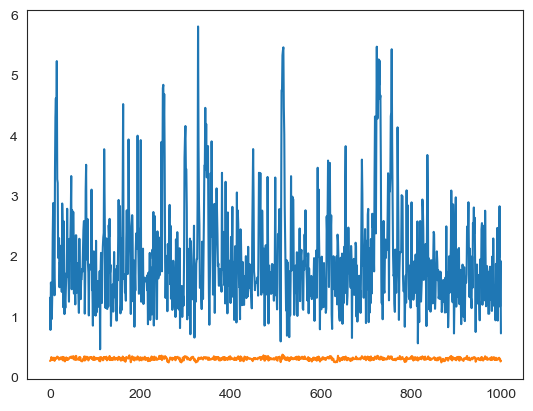

In [30]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s_new = hmc.sample(num_samples=1000) # Burnin

#plot the samples
plt.plot(s_new)

Text(0, 0.5, 'lengthscale')

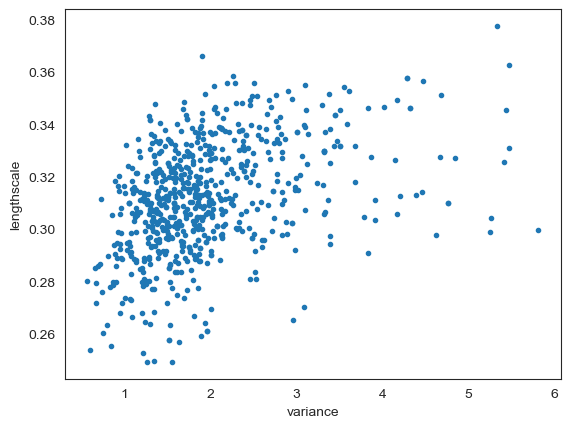

In [31]:
samples_new = s_new[300:] # cut out the burn-in period
plt.plot(samples_new[:,0], samples_new[:,1],'.')
plt.xlabel(labels[0]); plt.ylabel(labels[1])

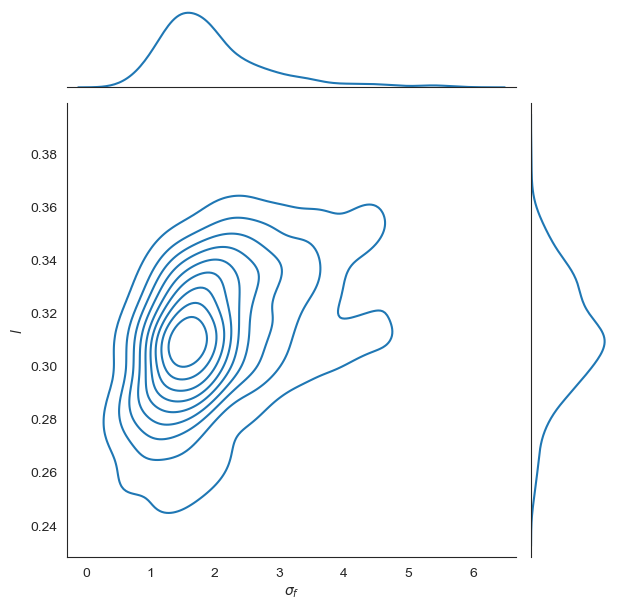

In [32]:
#Distribution of l and sigma
sns.jointplot(x=samples_new[:,0],y=samples_new[:,1], kind='kde')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

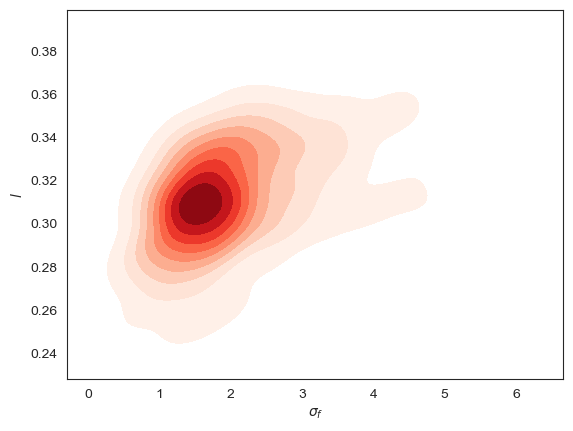

In [33]:
sns.set_style("white")
sns.kdeplot(x=samples_new[:,0], y=samples_new[:,1], cmap="Reds", fill=True)
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

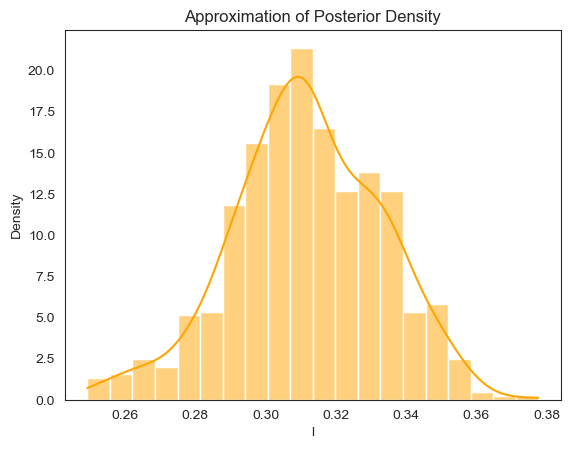

In [34]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples_new[:,1], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

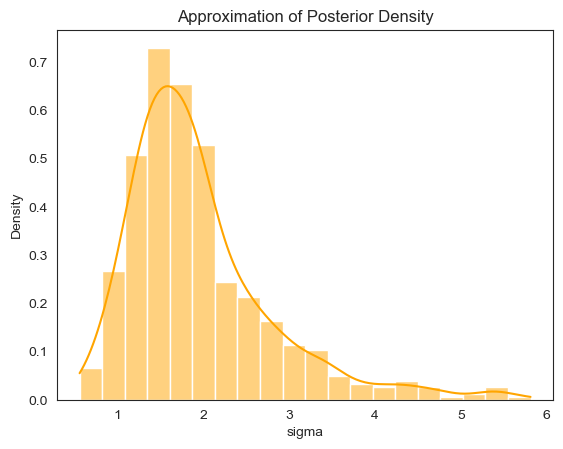

In [35]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples_new[:,0], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

<Figure size 640x480 with 0 Axes>

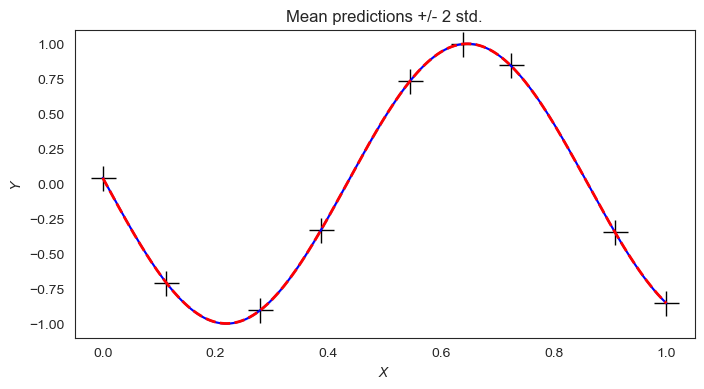

In [36]:
GPy_plot_post(m, Xnew, ynew)

In [37]:
#global error:
N = len(Xnew)
n = 200 # number of test points X*

#Xtest with true f(Xtest) values:
Xtest = np.linspace(min(Xnew), max(Xnew), n).reshape(-1,1)
ytest = f_scaled(Xtest,minX,maxX)

mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)

rmse = np.sqrt(np.mean(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])**2)) #predictions - targets
print(rmse)

0.0006051494504784804


In [38]:
#local error (max error)
np.max(np.abs(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])))

0.001582776712666767

Sources:
* https://nbviewer.org/github/SheffieldML/notebook/tree/master/GPy/